## Intro
This project is aimed at using causual inference techniques with wideley available and relevant data 

In July 2024, Crowdstrike had a widely reported data breach causing the stock price to drop 18% over the
next 3 days. This "bad event" is something companies are regularly worried about and I'm interested
in quantifying impact -- but naturally we dont want do design and experiment that will randomly cause
millions of government computers to crash over and over again. 

Examples of how this might transfer 

Suppose there is an outage that affects a certain region or population of users (in this case infastructure workers) 
IF you have a time series of performance by these groups, you may consider a difference-in-difference model to estimate the impact of the event. 

Note: This is an example where we look at one day returns of an event. In most cases, if we wanted to analyze price movements, we may be more interested in montly or yearly data. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import datetime 
import statsmodels.formula.api as smf 
from yahoo_fin import stock_info as si

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime 
import statsmodels.formula.api as smf 
from yahoo_fin import stock_info as si

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [2]:
def get_daily_prices(ticker,start_date, end_date):
    df = si.get_data(ticker, interval='1d', start_date=start_date, end_date=end_date)
    df.reset_index(inplace=True)  # Ensure the date is a column
    df.rename(columns={'index': 'date'}, inplace=True)  # Rename 'index' to 'date'
    df['price'] = df['adjclose']
    df = df[['date', 'price', 'ticker']]
    return df

In [3]:
def get_prices(tickerlist, start, end):
    all_prices = []  # Use a list to collect DataFrames
    for ticker in tickerlist:
        dailyprices_df = get_daily_prices(ticker, start, end)
        all_prices.append(dailyprices_df)
    df = pd.concat(all_prices)  # Concatenate all DataFrames at once
    return df

In [4]:
def run_diff_in_diff(df, event_date, treated):
    start_date = event_date - datetime.timedelta(days=180)
    
    # Create a copy of the filtered DataFrame
    df = df[(df['date'] >= start_date) & (df['date'] <= event_date)].copy()
    
    
    df['treated'] = np.where(df['ticker'] == treated, 1, 0)
    df['post'] = np.where(df['date'] >= event_date, 1, 0)
    df['treated_post'] = df['treated'] * df['post']

    formula = "returns ~ treated + post + treated_post"
    model = smf.ols(formula = formula, data=df).fit()

    return model

In [5]:
def difference_in_trends(df, event_date, treated):
    start_date = event_date - datetime.timedelta(days=100)
    
    # Create a copy of the filtered DataFrame
    df = df[(df['date'] >= start_date) & (df['date'] <= event_date)].copy()
    
    # Create the necessary columns using .loc
    df.loc[:, 'treated'] = np.where(df['ticker'] == treated, 1, 0)
    df.loc[:, 'trend'] = (event_date - df['date']).dt.days
    df.loc[:, 'treated_trend'] = df['treated'] * df['trend']
    
    # Define the formula and fit the model
    formula = "returns ~ treated + trend + treated_trend"
    model = smf.ols(formula=formula, data=df).fit()
    
    return model

In [6]:
start_date = '2023-01-01'
end_date = '2024-07-20'

event_date = pd.to_datetime('07-19-2024')
#'CRWD', 'MSFT', 'VTI', 'RPD', 'AAPL', 'NVDA' 
tickerlist = list(['CRWD', 'MSFT', 'VTI', 'RPD', 'FTNT', 'AAPL', 'NVDA', 'SPY'])
prices = get_prices(tickerlist, start_date, end_date)   
#create a returns column that caluclates the returns for each day
prices['return'] = prices.groupby('ticker')['price'].pct_change()


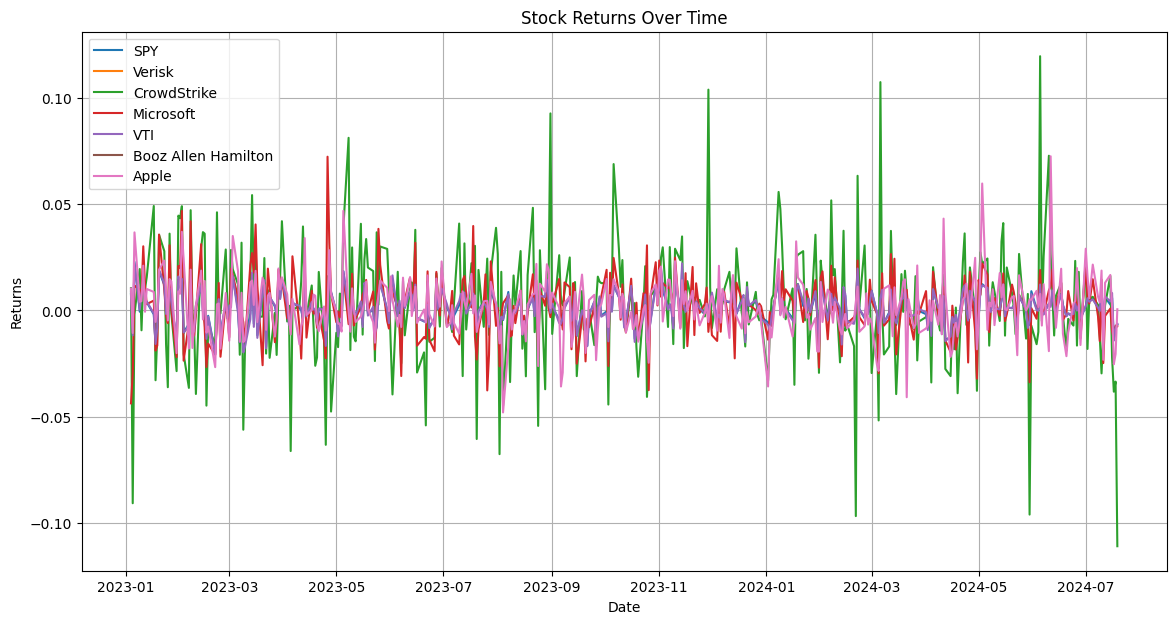

In [7]:
prices['returns'] = prices.groupby('ticker')['price'].pct_change()

bah = prices[prices['ticker'] == 'BAH']
vrs = prices[prices['ticker'] == 'VRSK']

plt.figure(figsize=(14, 7))




spy = prices[prices['ticker'] == 'SPY']
crwd = prices[prices['ticker'] == 'CRWD']
msft = prices[prices['ticker'] == 'MSFT']
vti  = prices[prices['ticker'] == 'VTI']
rpd = prices[prices['ticker'] == 'RPD']
aapl = prices[prices['ticker'] == 'AAPL']
nvda = prices[prices['ticker'] == 'NVDA']



plt.plot(spy['date'], spy['return'], label='SPY')
plt.plot(vrs['date'], vrs['return'], label='Verisk')
plt.plot(crwd['date'], crwd['return'], label='CrowdStrike')
plt.plot(msft['date'], msft['return'], label='Microsoft')
plt.plot(vti['date'], vti['return'], label='VTI')
plt.plot(bah['date'], bah['return'], label='Booz Allen Hamilton')
plt.plot(aapl['date'], aapl['return'], label='Apple')
plt.legend(loc = 'upper left')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Change interval as needed
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Stock Returns Over Time')

plt.grid(True)
plt.show()


In [8]:
prices[prices['date'] >= "2024-07-16"].iloc[:10,]

,date,price,ticker,return,returns
384,2024-07-16,369.049988,CRWD,-0.022047,-0.022047
385,2024-07-17,354.940002,CRWD,-0.038233,-0.038233
386,2024-07-18,343.049988,CRWD,-0.033499,-0.033499
387,2024-07-19,304.959991,CRWD,-0.111033,-0.111033
384,2024-07-16,448.711243,MSFT,-0.009781,-0.009781
385,2024-07-17,442.722015,MSFT,-0.013348,-0.013348
386,2024-07-18,439.577698,MSFT,-0.007102,-0.007102
387,2024-07-19,436.323547,MSFT,-0.007403,-0.007403
384,2024-07-16,278.241608,VTI,0.008236,0.008236
385,2024-07-17,274.313751,VTI,-0.014117,-0.014117


We see that on the day of the event, the stock return dropped by 11%, we want to look at the impact of the returns on that day. 


## Estimate Differnce-in-Differences Model

We're going to estimate returns against a dummy for being in the treated model, in this case is just Crowdstrike. We indicate post as the event date and an interaction between treated and post. 

In [9]:
event_date = pd.to_datetime('2024-07-19')
treated = 'CRWD'

model = run_diff_in_diff(prices, event_date, treated)
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     9.772
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           2.34e-06
Time:                        12:01:23   Log-Likelihood:                 2440.5
No. Observations:                1000   AIC:                            -4873.
Df Residuals:                     996   BIC:                            -4853.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0012      0.001      1.732   

Essentially, we are netting out competitor returns and market returns that happened on the same day. This way, if we saw a fall in Crowdstrike, but there was also a large market movement at the same time, we wouldn't give full credit from that drop in return to the crowdstrike breach. 

In this case, we see that ther was really nothing else going on. Our DID model gives us an estimated drop due to the breach that is almost identical to that days return. 

## Test Validation Assumptions

### Assumption 1: No difference trends prior to the event 

So we can see that our model is working as intended, but we'd like to do some validation work. 

In [10]:
placebo_date = event_date - datetime.timedelta(days=1)
treated = 'CRWD'

test_trend_mn = difference_in_trends(prices, placebo_date, treated)
print(test_trend_mn.summary())



                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.4351
Date:                Wed, 02 Oct 2024   Prob (F-statistic):              0.728
Time:                        12:01:23   Log-Likelihood:                 1352.9
No. Observations:                 560   AIC:                            -2698.
Df Residuals:                     556   BIC:                            -2680.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0025      0.002      1.308

For this test, we want to look at the data on the day prior to the event date, we want to see if there was a downward trend in the stock the day before. If this is the case, we can attribute some of the drop in returns to a downward trend. 

We estimated the same model but on a treated variable, a trend variable and then the interaction between the two (treated * trend). We see that the there is effectively a zero difference in trend (.00009129), with a p-value 0f 0.328 which indicates that the treated_trend variable is not statistically significant or has no effect on the trend. 

This helps validate our difference-in-difference model because it suggests that there is no evidence of a trend in the pre-period before our event. So we can't attribute any of the durastic change in returns on the 19th to a downward trend. 

### Assumption 2: Unbiasdness, placebo estimates should be close to zero.

In [11]:
placebo_date = event_date - datetime.timedelta(days = 1)
treated = 'CRWD'

placebo_model = run_diff_in_diff(prices, placebo_date, treated)
print(placebo_model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.281
Date:                Wed, 02 Oct 2024   Prob (F-statistic):              0.280
Time:                        12:01:23   Log-Likelihood:                 2419.6
No. Observations:                 992   AIC:                            -4831.
Df Residuals:                     988   BIC:                            -4812.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0013      0.001      1.812   

For this validation, we will run our difference-in-difference on only on the data prior to the event date. 

We'll take one example, say the day before. If we run the model on that day, we should see estimates close to zero.

Our treated post estimate is fairly close to zero and our P-Value of .225 is not statistically signiifcant which indicates the treated_post has no effect on the model. 

In [12]:
placebo_start = event_date - datetime.timedelta(days=120)
pre_event_dates = prices[(prices['date'] >= placebo_start) & (prices['date'] <= event_date)]['date']

pvalues = list()
betas = list()

# Loop through each date and run the diff-in-diff model
# Save the p-value and beta for the treated_post variable
for placebo_date in pre_event_dates:
    placebo_model = run_diff_in_diff(prices, placebo_date, treated)
    pvalues.append(placebo_model.pvalues['treated_post'])
    betas.append(placebo_model.params['treated_post'])
  

df = pd.DataFrame({'placebo_date': pre_event_dates, 'pvalue': pvalues, 'beta': betas})
print(df.describe())

#print the share of p-values that are less than 0.05

print((df['pvalue'] < 0.05).mean())

                        placebo_date      pvalue        beta
count                            664  664.000000  664.000000
mean   2024-05-20 06:04:20.240963840    0.583221   -0.003517
min              2024-03-21 00:00:00    0.000004   -0.104715
25%              2024-04-19 00:00:00    0.431381   -0.013483
50%              2024-05-20 00:00:00    0.602145   -0.002580
75%              2024-06-20 00:00:00    0.784580    0.007044
max              2024-07-19 00:00:00    0.985233    0.097522
std                              NaN    0.256867    0.023484
0.04819277108433735


We then can run our difference-in-difference model on a large number of days prior to the event, and get a sense of where our placebo tests lie. 



Looking at the distribution of placebo tests, we see that the median beta value is almost zero, along with a P value high enough for our results to be statistically significant



In [13]:
print("Share of pvalues less than 0.05: 4.8%".format((df['pvalue'] < 0.05).mean()))

Share of pvalues less than 0.05: 4.8%


Not Suprisingly, the placebo tests are not independent so we get 5% of p-values less than 0.05. THis suggest that we consider an empirical distribution as in the histogram below

In [14]:
df['betas'] = df['beta']
df['betas'].quantile([0.025, 0.975])


0.025   -0.038707
0.975    0.024578
Name: betas, dtype: float64

Running a 95% confidence interval on our placebo tests, we can expect daily volatility to be between
 -3.8% to +2.4%

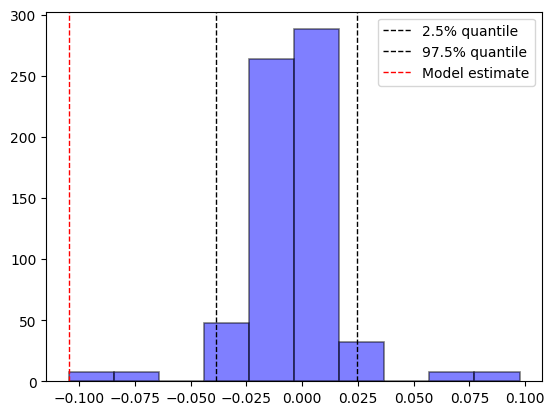

In [15]:

quantile_2_5 = df['betas'].quantile(0.025)
quantile_97_5 = df['betas'].quantile(0.975)
model_est = model.params['treated_post']

plt.hist(df['betas'], bins=10, alpha = 0.5, color = 'blue', edgecolor = 'black', linewidth = 1.2)
plt.axvline(x = quantile_2_5, color = 'black', linestyle = '--', linewidth = 1, label = '2.5% quantile')
plt.axvline(x = quantile_97_5, color = 'black', linestyle = '--', linewidth = 1, label = '97.5% quantile')
plt.axvline(x = model_est, color = 'red', linestyle = '--', linewidth = 1, label = 'Model estimate')
plt.legend(loc='upper right')
plt.show()

#the model should have most of the data around 0.000 and the event 
#should be a far outlier from the rest of the data



we see that most of the distribtion of beta values exist in hovering around 0.000, our model estimate's beta value is a far outliar of this distribution. So we are led to belive our model is not biased